In [241]:
#Nicolas Cardenas Valdez A01114959
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import tree
from matplotlib import pyplot as plt

# LIMPIEZA

In [242]:
data=pd.read_csv("iris.csv", index_col="Id")
data.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
Id,,,,,
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa


In [243]:
#El CSV no contiene NA pero sigue siendo bueno filtrarlos
data=data.dropna().copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 1 to 150
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  150 non-null    float64
 1   SepalWidthCm   150 non-null    float64
 2   PetalLengthCm  150 non-null    float64
 3   PetalWidthCm   150 non-null    float64
 4   Species        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 7.0+ KB


In [244]:
data.duplicated().sum() #Vemos que hay tres duplicados

3

In [245]:
data.columns

Index(['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm',
       'Species'],
      dtype='object')

Iris-virginica     50
Iris-versicolor    50
Iris-setosa        50
Name: Species, dtype: int64


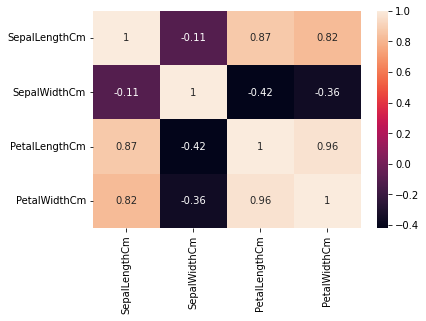

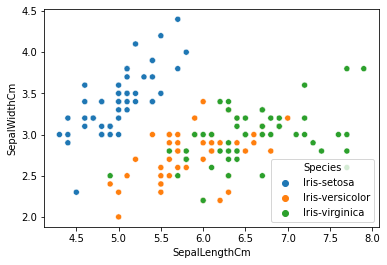

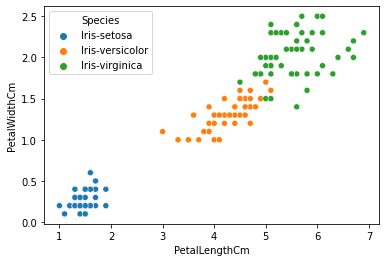

In [246]:
#Podemos ver que hay samples_sizes iguales para cada tipo de especie lo cual es bueno porque mejora nuestra calidad de la 
#informacion
print(data.Species.value_counts())

sns.heatmap(data = data.corr(), annot=True)
plt.show()
#Como podemos ver en el mapa de correlaciones, tenemos unas muy fuertes:
#entre petalwidthcm y sepallengthcm, y sepallengthcm con petallength cm asi que analizaremos estas relaciones

sns.scatterplot(x = 'SepalLengthCm', y = 'SepalWidthCm', data = data, hue = 'Species')
plt.show()

sns.scatterplot(x = 'PetalLengthCm', y = 'PetalWidthCm', data = data ,hue ='Species')
plt.show()
#Como podemos ver en cuanto al sepal tenemos mas variabilidad y hay muchos datos revueltos
#En cuanto a petal vemos que hay una clara uniformidad y un comportamiento que en cuanto supen las medidas del petal 
#en ambas direcciones, vemos que tambien cambia el tipo de especie.
#Tiene muy buena agrupacion lo cual indica que nuestro modelo puede llegar a ser muy preciso

# MODELO

In [247]:
#Normalmente hariamos lo siguiente:
#data.join(pd.get_dummies(data.Species,prefix="species-"),how="inner").copy()
#data=data.drop(["Id","Species"],axis=1).copy()

#Sin embargo, lo que queremos decifrar es el tipo de especie, por lo tanto lo tomamos como la variable dependiente
X = data.drop(['Species'], axis = 1)
X.head()

Y = data['Species']

In [248]:
#Agregamos random state para ser consistentes en la comparacion
x_train,x_test,y_train,y_test=train_test_split(X,Y, test_size=0.25, random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((112, 4), (38, 4), (112,), (38,))

In [249]:
#Usaremos DecisionTreeClassifier debido a que tenemos variables categoricas, queremos decidir una variable categorica a partir de multiples factores numericos, lo cual es perfecto para un DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

#Primero probaremos el modelo sin cambiar ningun parametro
modelo = DecisionTreeClassifier(random_state=0)

In [250]:
modelo.fit(x_train,y_train)

DecisionTreeClassifier(random_state=0)

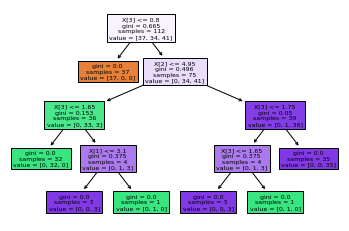

In [251]:
tree.plot_tree(modelo, filled = True)
plt.show()
#Vemos que el arbol muestra muchas decisiones 

# METRICA

In [252]:
#Utilizaremos como metricas el accuracy_score y confusion_matrix de parte de la libreria de sklearn 
#ya que estas nos van a dar una idea de que tan preciso es el modelo (a partir de varias otras metricas) y la matriz
#nos ayuda a determinar como se esta equivocando el modelo y cuanto. Podriamos usar el MSE y otras metricas de errores
#pero el accuracy_score toma en consideracion esto de manera indirecta.
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#Primero hay que ver cuales features son las mas importantes para el modelo del modelo pasado:
print(modelo.feature_importances_)
#Vemos que el factor mas importante es la ultima columna que es "petal width" y no toma en consideracion la primera columna

predicciones=modelo.predict(x_test)

ac = accuracy_score(y_test,predicciones)
print(ac)

cm = confusion_matrix(y_test, predicciones) 
print(cm)

#Tenemos un excelente accuracy_score lo cual nos indica que nuestro modelo es bueno, la confusion matrix tambien muestra paraledidad, es decir, se esta equivocando parejamente

[0.         0.02014872 0.39927524 0.58057605]
0.9736842105263158
[[13  0  0]
 [ 0 15  1]
 [ 0  0  9]]


[0.00475646 0.         0.03869345 0.95655009]


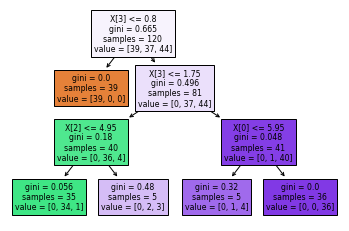

1.0
[[11  0  0]
 [ 0 13  0]
 [ 0  0  6]]
0.9666666666666667
[[39  0  0]
 [ 0 34  3]
 [ 0  1 43]]


In [253]:
#Vemos que tenemos es un muy buen modelo pero hay que probar si cambiando los hiperparametros podemos mejorar el accuracy_score

#Primero que nada habra que analizar el arbol del modelo pasado lo cual como podemos ver 4 steps son demasiados
#el ultimo paso consiste de muy poco samples por lo mas seguro es que solo nos este quitando accuracy asi que lo limitaremos a 3 
#para generar mejores decisiones, esto es un ejemplo de sobreajuste. Tambien cambiaremos el min_samples_leaf
#para igualmente evitar que no haya decisiones con samples pequenos que creo que nos estan alterando las decisiones
#Agregamos random state para ser consistentes en la comparacion
modelo2= DecisionTreeClassifier(max_depth = 3, min_samples_leaf=5, random_state=0)

#Tambien dividiremos de nuevo los datos a un split de 80-20 para tener un sample size un poco mas grande para
#ver el nuevo arbol y esperar mejores sample sizes
x_train2,x_test2,y_train2,y_test2=train_test_split(X,Y, test_size=0.2, random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

#Fiteamos
modelo2.fit(x_train2,y_train2)

#Checamos de nuevo las importancias
print(modelo2.feature_importances_)
#Vemos que practicamente esta solo considerando la ultima columna lo cual nos indica que podriamos generar
#un muy buen modelo a partir de solo petal-width

#Vemos de nuevo el arbol
tree.plot_tree(modelo2, filled = True)
plt.show()

#Checamos nuestra nueva accuracy con el set de pruebas
predicciones2=modelo2.predict(x_test2)

ac = accuracy_score(y_test2,predicciones2)
print(ac)

cm = confusion_matrix(y_test2, predicciones2) 
print(cm)


#Tenemos un accuracy_score de 100%, lo cual un buen numero considerando que no contamos con miles de datos para el entrenamiento.
#Sin embargo esto es para solo el test size
#Nuestra matriz de confusion se reduce a 0 porque no tenemos errores pero tambien en parte porque reducimos el sample size

#Mediremos ahora pero con el set de training solo para tenerlo igualmente de referencia
predicciones2=modelo2.predict(x_train2)

ac = accuracy_score(y_train2,predicciones2)
print(ac)

cm = confusion_matrix(y_train2, predicciones2) 
print(cm)
#Vemos que ahora no es 100, significa que nuestro modelo no es perfecto si no que solo es perfecto para los datos test en esta ocasion
#Sin embargo, tenemos todavia un porcentaje de accuracy de casi 97% lo cual significa que no tenemos sobreajuste para solo los datos test

#En conclusion pudimos determinar que modelo de machine learning utilizar (DecisionTreeClasssifier para variables categoricas)
# y armar un modelo base con todos los hiperparametros en default y apartir de lo que pudimos observar del arbol de
#decisiones, poder regularizar esos hiperparametros de entrada para obtener un mejor modelo que no sufre de sobre-ajuste.
